In [18]:
import os
os.environ['HEASOFTPYDIR']= os.path.split(os.getcwd())[0]

import sys
sys.path.insert(0,os.environ['HEASOFTPYDIR'])
sys.path


from matplotlib.pyplot import *
import glob

import heasoftpy as hsp
import xspec

from astropy.table import Table
from astropy.time import Time
from astropy.io import fits
import astropy.units as u

# Set up the NICER obsid directory

We'll assume the user has downloaded the NICER observation directory for OBSID ``4142010107`` in a directory called ``/Users/mcorcora/tmp/nicer``

That is the directory ``/Users/mcorcora/tmp/nicer/4142010107`` contains the ``xti``, ``auxil`` and ``hk`` directories containing the standard archived data for the observation

We'll put the output from nicerl2 in an output directory separate from the input directory

In [4]:
cwd = os.getcwd()
os.chdir(nicerdatadir)

In [2]:
nicerdatadir = os.path.join(os.environ['HOME'],'tmp/nicer')
nicerobsID = '4020180460'
obsdir = os.path.join(nicerdatadir, nicerobsID)

# place cleaned output in a separate directory
outdir =  os.path.join(os.environ['HOME'],'tmp/nicer/','nicerl2_output/'+nicerobsID+'_out')
# if outdir doesn't exist, create it
if not os.path.exists(outdir):
    os.makedirs(outdir)
    print(f'Created {outdir}')
# copy the mkf file from the input directory to the outdir

In [3]:
mkf = os.path.join(obsdir,'auxil',f'ni{nicerobsID}.mkf')
if os.path.exists(mkf):
    # see if mkf is gzipped    
    cmd = f'cp {mkf} {outdir}/.'
    stat=os.system(cmd)
    mkf = os.path.join(outdir, os.path.split(mkf)[1])
    print(f'Setting mkf file to {mkf}')
elif os.path.exists(mkf+'.gz'):
    #try to copy gzipped mkf     
    cmd = f'cp {mkf}.gz {outdir}/.'
    print(cmd)
    os.system(cmd)
    mkf = os.path.join(outdir, os.path.split(mkf)[1])
    print(f'Setting mkf file to {mkf}')
    #cmd = f'gunzip -f {mkf}.gz'
    #print(cmd)
    #stat=os.system(cmd)
cmd = f'chmod u+w {mkf}*'
print(cmd)
stat = os.system(cmd)

cp /Users/mcorcora/tmp/nicer/4020180460/auxil/ni4020180460.mkf.gz /Users/mcorcora/tmp/nicer/nicerl2_output/4020180460_out/.
Setting mkf file to /Users/mcorcora/tmp/nicer/nicerl2_output/4020180460_out/ni4020180460.mkf
chmod u+w /Users/mcorcora/tmp/nicer/nicerl2_output/4020180460_out/ni4020180460.mkf*


# Create the nicerl2 task

In [5]:
tstart = Time.now()
print(f'Start at: {tstart.iso[:19]}')
nicerl2 = hsp.HSPTask('nicerl2')

nicerl2.clobber="yes"
#nicerl2.cldir=outdir
#nicerl2.mkffile=mkf
# add the KP values to the mkf file during nicerl2 processing
nicerl2.geomag_path="https://heasarc.gsfc.nasa.gov/FTP/caldb/data/gen/pcf/geomag/"
nicerl2.geomag_columns="kp_noaa.fits(KP)"

resl2 = nicerl2(indir=nicerobsID, noprompt=True, cldir=outdir, mkfile=mkf)

tend = Time.now()
print(f'End at: {tend.iso[:19]}')
print(f'nicerl2 took: {(tend.mjd-tstart.mjd)*86400} seconds')

if resl2.returncode != 0:
    print('\n')
    for o in resl2.output[:]:
        print(o)


Start at: 2021-12-18 18:08:30
End at: 2021-12-18 18:11:36
nicerl2 took: 185.77480078674853 seconds


# Extract products from cleaned events file

In [6]:
clevt = f'{outdir}/ni{nicerobsID}_0mpu7_cl.evt'
phafile = f'{outdir}/ni{nicerobsID}_0mpu7_cl.pha'
lcfile = f'{outdir}/ni{nicerobsID}_0mpu7_cl.lc'
res = hsp.extractor(filename=clevt, phafile=phafile, clobber='yes', binlc=10.0,fitsbinlc=lcfile, 
                    eventsout='NONE', imgfile='NONE', regionfile='NONE', timefile='NONE', tcol='TIME',
                   ecol='PI', xcolf='RAWX', xcolh='RAWX',ycolf='RAWY', ycolh='RAWY', )

# Analyzing NICER spectra

In [10]:
# get the on-axis rmf
res = hsp.quzcif(mission='nicer', instrument='xti',detector='-',
             filter='-', date='-', time='-',expr='-',codename='MATRIX')
rmf = [x.split()[0] for x in res.output if 'nixtiref'  in x][0]

# get the on-axis arf
res = hsp.quzcif(mission='nicer', instrument='xti',detector='-',
             filter='-', date='-', time='-',expr='-',codename='SPECRESP')
arf = [x.split()[0] for x in res.output if 'nixtiaveonaxis'  in x][0]


In [28]:
xspec.AllData.clear()
spec = xspec.Spectrum(phafile)
spec.response = rmf
spec.response.arf = arf
spec.ignore('0.0-0.3, 10.0-**')


1 spectrum  in use
 
Spectral Data File: /Users/mcorcora/tmp/nicer/nicerl2_output/4020180460_out/ni4020180460_0mpu7_cl.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.015e+01 +/- 2.220e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-1501
  Telescope: NICER Instrument: XTI  Channel Type: PI
  Exposure Time: 1423 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

Fit statistic  : Chi-Squared                99491.94     using 1501 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number: 1

Test statistic : Chi-Squared                99491.94     using 1501 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number(s): 1 

 Null hypothesis probability of 0.00e+00 with 1496 degrees of freedom
 Current data and model not fit yet

In [29]:
model = xspec.Model('wabs*bknpow')
xspec.Fit.perform()


Model wabs<1>*bknpower<2> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   wabs       nH         10^22    1.00000      +/-  0.0          
   2    2   bknpower   PhoIndx1            1.00000      +/-  0.0          
   3    2   bknpower   BreakE     keV      5.00000      +/-  0.0          
   4    2   bknpower   PhoIndx2            2.00000      +/-  0.0          
   5    2   bknpower   norm                1.00000      +/-  0.0          
________________________________________________________________________


Fit statistic  : Chi-Squared              1.146821e+08     using 969 bins.

Test statistic : Chi-Squared              1.146821e+08     using 969 bins.
 Null hypothesis probability of 0.000000e+00 with 964 degrees of freedom
 Current data and model not fit yet.
                                   Parameters
Chi-Squared  |beta|/N    Lvl          1:nH    2:PhoIndx1      3:BreakE    4:PhoIndx2        5:norm
44865        1293.48      -1   

<IPython.core.display.Javascript object>


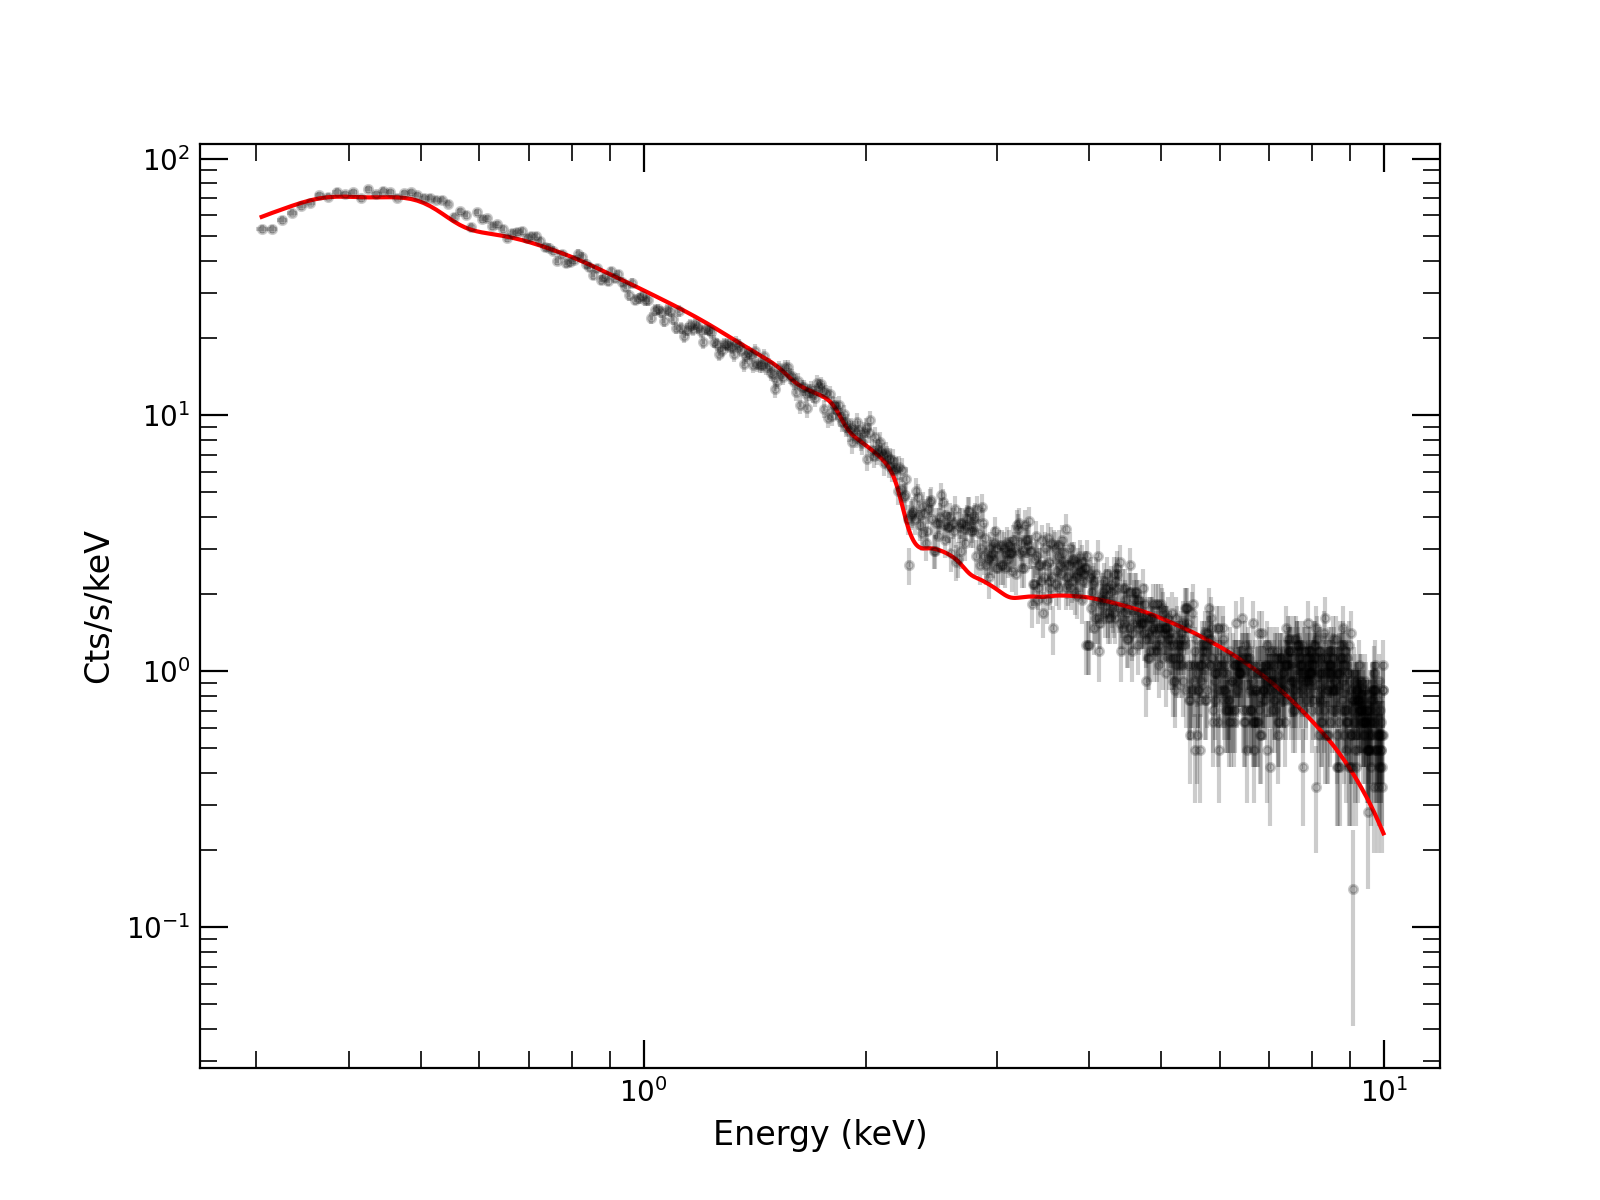

In [30]:
%matplotlib notebook
xspec.Plot.device='/null'
xspec.Plot.xAxis='keV'
xspec.Plot('lda')
cr=xspec.Plot.y()
crerr = xspec.Plot.yErr()
en = xspec.Plot.x()
enwid = xspec.Plot.xErr()
mop = xspec.Plot.model()

fig = figure(figsize=[8,6])
ylabel('Cts/s/keV', fontsize=12)
xlabel('Energy (keV)', fontsize=12)
yscale('log')
xscale('log')
errorbar(en, cr, xerr=enwid, yerr=crerr, fmt='k.', alpha=0.2)
plot(en, mop,'r-')